# AI in Industry project
# Flare prediction
- Ildebrando Simeoni - ildebrando.simeoni@studio.unibo.it
- Davide Femia - davide.femia@studio.unibo.it
- Riccardo Falco - riccardo.falco2@tudio.unibo.it
- Vincenzo Collura - vincenzo.collura2@studio.unibo.it


##The problem

###Mathematical background

A stochastic differential equation (SDE) is a differential equation in which one or more of the terms is a stochastic process, resulting in a solution which is also a stochastic process. SDEs are used to model various phenomena such as stock prices or physical systems subject to thermal fluctuations. Typically, SDEs contain a variable which represents random white noise calculated as the derivative of Brownian motion or the Wiener process.

A typical SDE has the form


$$ dXt = a(Xt, t) dt + b(Xt, t) dWt \hspace{2cm}(1)$$

Where the coefficients are $a(x, t)$, which is the drift coefficient, and $b(x, t)$, which is the noise coefficient.

###Our problem

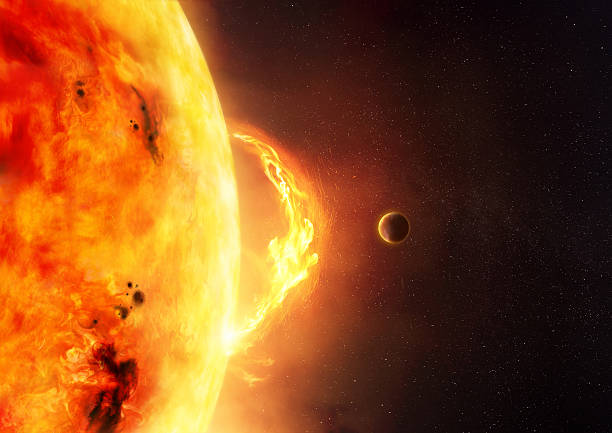

The model, derived from Tavecchio et al. 2020 (https://arxiv.org/pdf/2004.09149.pdf) assumes the following stochastic differential equation (SDE):

$$ dX = \theta (\mu − X)d_t + \sigma XdW_t \hspace{2cm}  (0.1)$$

specified by the parameters $\theta$ (the inverse of the time scale of the drift term), $\mu$ (equilibrium
value for 𝑋) and $\sigma$ (coefficient of the stochastic term).

Eq. (0.1) describes a quite simple underlying dynamics: the deterministic (drift) term pushes
the system toward an equilibrium value $\mu$, while the evolution is disturbed by a random noise
whose amplitude is proportional to the actual value of 𝑋. Hence, high states, characterized
by large 𝑋, will also display the largest fluctuations.
SDE are commonly solved by using standard numerical schemes. 

For the specific SDE we are considering, the [Milstein method](https://en.wikipedia.org/wiki/Milstein_method) is appropriate. Applying this method we obtain the following:
$$ X_{i+1} = X_i + \theta(1 − x_i)\Delta t +\sigma W_iX_i \sqrt{\Delta t}+\frac{1}{2}\sigma^2 X_i \Delta t (W^2_i-1) \hspace{2cm} (0.2)$$
<!-- 
𝑋𝑖+1 = 𝑋𝑖 + 𝜃(1 − 𝑥𝑖)Δ𝑡 + 𝜎𝑊𝑖𝑋𝑖
√
Δ𝑡 +
1
2
𝜎2𝑋𝑖Δ𝑡(𝑊2
𝑖 − 1) (0.2) 
-->

where $W_i$ is a random variable chosen from a normal distribution with mean 0 and standard deviation 1, i.e. $W_i \sim N(0,1)$.

## Libraries

In [ ]:
%load_ext autoreload
%autoreload 2
from Libs.load_data import DataLoader
from Libs import flares_plot as fplt
from Libs.threshold import get_labels_physic, get_labels_KDE, get_labels_quantile, get_labels_quantile_on_run
import numpy as np
import pandas as pd

## Data generation

In [ ]:
'''
TO DO: Intro, abbiamo generato, come da lei suggerito, un ampio dataset sintetico, comprendente non solo le configurazioni di parametri "standard" 
fornite nel paper, ma anche facendo variare questi ultimi, ottenendo così una griglia di 30 x 4 x 4 x 4 x 10 x 1000 samples
'''

In [ ]:
# initialize data loader
data_loader = DataLoader()
# get the grid
grid = data_loader.get_grid()
# get params dictionary
params = data_loader.get_params()
params

{'run': 30,
 'sigma': [0.3, 0.4, 0.5, 0.6],
 'theta': [0.01, 0.1, 0.5, 3],
 'mu': [0.8, 0.9, 1, 1.1],
 'delta': [0.01, 0.05, 0.1, 0.2, 0.25, 0.3, 0.4, 0.5, 0.6, 0.7],
 'N': 1000}

##Data inspection
In the following paragraph the data generated are carefully inspected, in particular the following informations are shown:


*   a comparison between the histogram and the pdf from the paper
*   cella sotto
*   histograms of data by changing one parameter at a time and leaving the others unchanged 
*   examples of time series as individual parameters change



In [ ]:
# TO DO: Commento comparazione istrogramma vs pdf

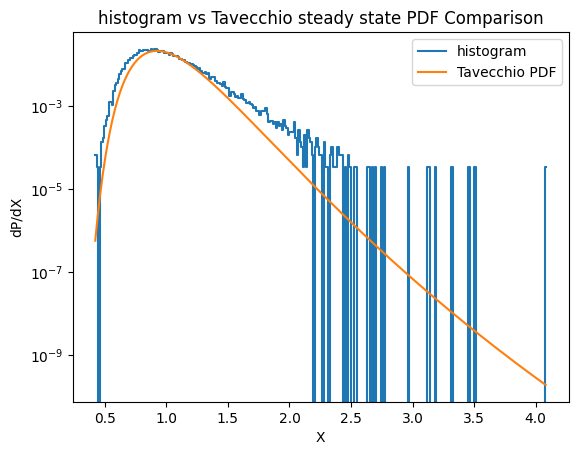

In [ ]:
run, mu, sigma, theta, delta = 0, 1, 0.5, 3, 0.2
title = 'histogram vs Tavecchio steady state PDF Comparison'
fplt.plot_grid_PDF(grid, params, nbins=300, run=run, sigma=sigma, theta=theta, mu=mu, delta=delta, 
                   on_run=False, dstep=1e-2, title=title)

In [ ]:
# TO DO: Commento cella sotto

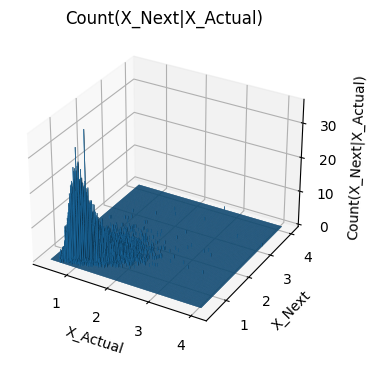

In [ ]:
normalize=False
if normalize:
    title = 'P(X_Next|X_Actual)'
else:
    title = 'Count(X_Next|X_Actual)'
fplt.histogram_next_given_actual(grid, params, nbins=300, run=run, sigma=sigma, theta=theta, mu=mu, delta=delta, 
                                 on_run=False, normalize=normalize, title=title)

### Varying theta

In [ ]:
# TO DO: breve descrizione del parametro che si sta facendo variare e considerazioni sui risultati ottenuti nei due grafici sotto (e.g. le time series non variano molto al 
# variare del parametro x, oppure se variano come lo fanno, giusto 1/2 righe)

In [ ]:
# TO DO: controllare che la sintassi delle funzioni sia coerente con gli ultimi push, l'idea è di plottare una run di time series al variare di un parametro e plottare
# poi gli istogrammi per quella variazione di parametro su tutte le run

In [ ]:
fplt.plot_grid_datapoints(grid, params, mu=mu, sigma=sigma, theta=theta, delta=delta, num_run = 5, variation='theta')

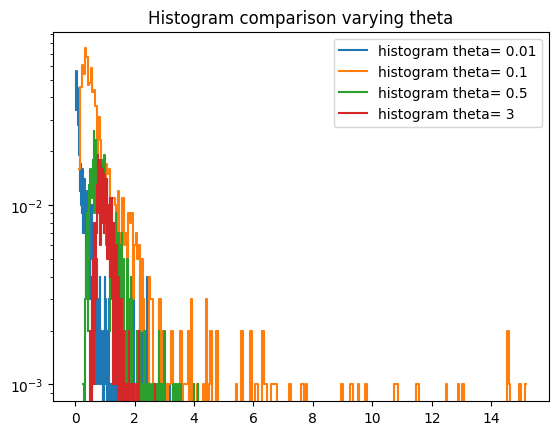

In [ ]:
title = 'Histogram comparison varying theta'
fplt.plot_histograms(grid, params, nbins=300, sigma=sigma, mu=mu, delta=delta, variation='theta', on_run=True, title=title);

###Varying sigma

In [ ]:
# TO DO: breve descrizione del parametro che si sta facendo variare e considerazioni sui risultati ottenuti nei due grafici sotto (e.g. le time series non variano molto al 
# variare del parametro x, oppure se variano come lo fanno, giusto 1/2 righe)

In [ ]:
# TO DO: copiare le due celle sopra anche per il variare di sigma e mu

###Varying mu

In [ ]:
# TO DO: breve descrizione del parametro che si sta facendo variare e considerazioni sui risultati ottenuti nei due grafici sotto (e.g. le time series non variano molto al 
# variare del parametro x, oppure se variano come lo fanno, giusto 1/2 righe)

In [ ]:
# TO DO: al variare di delta non possiamo plottare gli istogrammi, ma ci conviene almeno mostrare una run in cui varia delta?

##Data labeling

Anomaly detection has been performed in order to obtain labeled samples from the time series data, being flares considered as anomalies in the normal behaviour of the star.

An handcrafted definition of flares has been adopted not having any official feedback from INAF

###Physics based method

In [ ]:
# TO DO: descrizione metodo, in questo caso quali parametri sono stati usati per settare la threshold e breve commento sui risultati visibili

In [ ]:
physic_labels = get_labels_physic(grid, params, alpha=2)
run, mu, sigma, theta, delta = 4, 0.8, 0.3, 0.1, 0.2
fplt.plot_grid_datapoints(grid, params, mu=mu, sigma=sigma, theta=theta, delta=delta,
                          num_run=5, variation='run', labels=physic_labels, title='physic labels')

### KDE

In [ ]:
# TO DO: come sopra, ma con descrizione del problema del labeling di picchi non superiori a mu, che per noi non sono anomalie ma per KDE si

In [ ]:
kde_labels = get_labels_KDE(grid, params)
fplt.plot_grid_datapoints(grid, params, mu=mu, sigma=sigma, theta=theta, delta=delta,
                          num_run=5, variation='run', labels=kde_labels, title='kde labels')

### Quantile method

In [ ]:
# TO DO: come sopra, ma con problema di troppi samples labelati come anomalie, forse per i valori di X nelle varie e diversificate run

In [ ]:
quantile_labels = get_labels_quantile(grid, params, percentile = 0.7)
fplt.plot_grid_datapoints(grid, params, mu=mu, sigma=sigma, theta=theta, delta=delta,
                          num_run=5, variation='run', labels=quantile_labels, title='quantile labels')

###Best method

After a carefull examination of the anomaly detection methods that have been implemented, the simplest yet the most effective one has been selected. Namely the pyhsics based method.

Here the performance of this method with a random run of the "best" set of parameters is shown

In [ ]:
run = 4
labels_best = physic_labels
bindexes = data_loader.get_standard_indexes()
X_best = data_loader.get_standard_values(run=run)
best_labels = labels_best[run, bindexes[0], bindexes[1], bindexes[2], bindexes[3], :]
fplt.plot_serie(X_best, labels=best_labels, title='random run on the best parameters and best labelling method')

In [ ]:
# TO DO: commento buoni risultati del metodo, visivamente coglie le anomalie che ci aspettavamo

## Dataset creation

In [ ]:
# TO DO: 
# - spiegazione separazione in windows delle time series, come abbiamo tunato le dimensioni e l'overlapping 
# - spiegazione ristrutturazione del problema come un problema di binary classification, settando a 0 le finestre non seguite da anomalia, 1 altrimenti e definizione di finestra anomala per noi

In [ ]:
# TO DO: usare la nuova funzione pushata da Davide per creare il dataset, spiegando cosa fa e quali sono i vari parametri passabili

In [ ]:
best_Xs = grid[:, bindexes[0], bindexes[1], bindexes[2], bindexes[3], :]
best_labels = labels_best[:, bindexes[0], bindexes[1], bindexes[2], bindexes[3], :]

window_size = 100
overlap_size = 0
label_treshold = 10
stride = window_size - overlap_size
num_windows = (best_Xs.shape[-1]-window_size)//stride + 1

windows = np.zeros((best_Xs.shape[0]*(num_windows-1),window_size))
windows_label = np.zeros((best_labels.shape[0]*(num_windows-1),window_size), dtype='bool')


for i in range(best_Xs.shape[0]):
    tmp_windows = np.array([best_Xs[i,j:j+window_size] for j in range(0,stride*num_windows,stride)])
    tmp_windows_labels = np.array([best_labels[i,j:j+window_size] for j in range(0,stride*num_windows,stride)])
    windows[i*(num_windows-1):(i+1)*(num_windows-1)] = tmp_windows[:-1,:]
    windows_label[i*(num_windows-1):(i+1)*(num_windows-1)] = tmp_windows_labels[1:,:]

windows_label = np.sum(windows_label, axis=-1)
windows_label[windows_label<label_treshold] = 0
windows_label[windows_label>=label_treshold] = 1

windows_df = pd.DataFrame(windows, columns=[f't_{i}' for i in range(windows.shape[-1])])
label_df = pd.DataFrame({'future_flare':windows_label})
labelled_windows_df = pd.concat([windows_df, label_df], axis=1)

labelled_windows_df



,t_0,t_1,t_2,t_3,t_4,t_5,t_6,t_7,t_8,t_9,...,t_91,t_92,t_93,t_94,t_95,t_96,t_97,t_98,t_99,future_flare
0,1.000000,0.987600,1.015113,1.102188,1.172260,1.002175,1.102727,1.011016,0.972454,1.241815,...,0.546387,0.563971,0.500667,0.538432,0.752067,0.769070,0.768488,0.703136,0.733613,0
1,0.549520,0.438043,0.434294,0.563741,0.498435,0.412277,0.416751,0.414491,0.466468,0.471037,...,0.055895,0.050392,0.044550,0.044228,0.044579,0.044516,0.039507,0.048195,0.057360,0
2,0.061525,0.087007,0.077271,0.096791,0.078541,0.104705,0.095392,0.079260,0.097754,0.097792,...,0.050622,0.043392,0.040332,0.046251,0.033282,0.039079,0.041501,0.043818,0.045565,0
3,0.045556,0.038642,0.037012,0.042088,0.044293,0.044916,0.046896,0.044465,0.047284,0.058761,...,0.055748,0.048625,0.044515,0.036775,0.040404,0.037823,0.046907,0.037064,0.039400,0
4,0.046389,0.049879,0.056352,0.070357,0.077249,0.073005,0.089421,0.088629,0.115593,0.104994,...,0.037439,0.042885,0.037431,0.043424,0.046689,0.043090,0.039667,0.033655,0.033167,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
265,0.136265,0.135381,0.113545,0.092947,0.087141,0.093313,0.093272,0.110813,0.139549,0.138766,...,0.541112,0.609180,0.521523,0.584934,0.500284,0.455581,0.488986,0.406435,0.341604,0
266,0.394594,0.460922,0.546488,0.507126,0.501114,0.410633,0.406541,0.402621,0.360057,0.345067,...,0.092304,0.095294,0.102692,0.112000,0.102340,0.094716,0.092298,0.078835,0.080569,0
267,0.108585,0.122962,0.148420,0.149899,0.200966,0.156729,0.180727,0.144204,0.127355,0.117634,...,0.038804,0.035023,0.033061,0.038071,0.034692,0.029451,0.034816,0.033281,0.037952,0
268,0.049546,0.045011,0.043080,0.039333,0.038166,0.037105,0.041831,0.043947,0.043349,0.055392,...,2.014885,2.247014,2.283424,2.355769,2.438859,2.514316,3.113682,2.864890,3.196054,1


### Class unbalancement

In [ ]:
# TO DO: problema del class unbalancement e di come lo risolveremo poi con i modelli (i.e. tentativo di downsampling, class weighting che funziona meglio)

In [ ]:
labelled_windows_df['future_flare'].value_counts()

0    249
1     21
Name: future_flare, dtype: int64